## Model Selection and Putting it all together

*a priori* we do not know which model will perform the best. Depending on the data, simple models (such as linear regression) may be the most performant, while for other data, complex deep learning algorithms. It is important to note, THE MOST COMPLEX ALGORITHM IS NOT ALWAYS THE BEST PERFORMING. As a result, multiple models are tested initially and their performance evaluated. The top performing (or top n performing) are then down selected for more significant optimization. 

In [1]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from skopt.callbacks import DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_auc_score, precision_score, recall_score, accuracy_score, \
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
RootDir = '\\'.join(os.getcwd().split('\\')[0:-2])
os.chdir(RootDir)

In [3]:
%run "./notebooks/common/function_library.ipynb"

In [4]:
train_impute = pd.read_csv('data/train_smote.csv')
test_impute = pd.read_csv('data/test_impute.csv')

In [5]:
train_features = train_impute.columns[1:]
target_feature = 'readmit_flag'

# Get X/y
X_train = train_impute[train_features]
X_test = test_impute[train_features]
y_train = train_impute[target_feature]
y_test = test_impute[target_feature]

In [6]:
# Json files containig hyperparameters. 
param_files = [
    'lr_params.json',
    'knn_params.json',
    'svm_params.json',
    'mlp_params.json',
    'rf_params.json',
    'gb_params.json',
]

param_dict = dict()

for iFile in param_files:
    iKey = iFile.split('_')[0]
    with open(os.path.join('input',iFile),'r') as f:
        params = json.load(f)
        param_dict[iKey] = BuildSamplingDict(params)

### Model Types 

Many different models exist for machine learning and deep learning applications, with new architectures being developed and released every day. Below, we test some of the most common models, which are briefly outlined and explained below.

#### Logistic Regression

Perhaps one of the best known models, logistic regression fits a first order polynomial with parameters for each feature, which constitute the weight to the prediction output. Non-linearity can be introduced by fitting to a polynomial of degree n. 

For more see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

#### K-Nearest Neighbors

An unsupervised learning approach, data is ordered into multiple clusters corresponding to different classes using some specified metric (often distance). New preidctions can be made by finding the cluster closest in distance to the data point of interest.  

For more see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

#### Support Vector Machine

Support vector machines work by drawing boundaries between different classes in the subspace of features. This effectively separates the classes into different subspaces, allowing predictions of new features by identifying which subspace they are present in.

For more see https://scikit-learn.org/stable/modules/svm.html

#### Multi-layer Perceptron

A simple neural network, this multilayer perceptron model is comprised of an input layer, single hidden layer and output layer. 

For more see https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

#### Random Forest

Previosly described, an ensemble method leveraging multiple decision trees

For more see https://scikit-learn.org/stable/modules/svm.html

#### Gradient Boosting

Another ensemble method using tree-based methods. The primary distinction is the incorporation of coefficients to fit the trees to the residuals (errors). This allows the model to focus on classes that is makes more mistakes

For more see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [7]:
estimator_dict = {
    'lr': LogisticRegression(max_iter=1000),
    'knn': KNeighborsClassifier(),
    'svm': SVC(probability=True),
    'mlp': MLPClassifier(max_iter=1000),
    'rf': RandomForestClassifier(),
    'gb': GradientBoostingClassifier()
}

In [8]:
model_dict = dict()

for iKey in estimator_dict:

    print(f'##### Now processing model {iKey} #####')

    model_dict[iKey] = TuneHyperParameters(
        X_train=X_train, y_train=y_train, estimator=estimator_dict[iKey],param_dict=param_dict[iKey])
    
    test_score = EvaluateModel(X_test=X_test,y_test=y_test,estimator=model_dict[iKey])
    print(f'  > Test score was {test_score}')   

##### Now processing model lr #####
  > Test score was 0.505319345561544
##### Now processing model knn #####
  > Test score was 0.5462956802034584
##### Now processing model svm #####


C:\Users\ggray15\anaconda3\envs\py310_datascience\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\ggray15\anaconda3\envs\py310_datascience\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  > Test score was 0.5667783026888756
##### Now processing model mlp #####
  > Test score was 0.5333022822543083
##### Now processing model rf #####
  > Test score was 0.5795536037734454
##### Now processing model gb #####
  > Test score was 0.6102202408676558


##### Now processing model lr #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.9473251028806584
F1 Score: 0.015384615384615385
AUC: 0.505319345561544
Precision: 0.0136986301369863
Recall: 0.017543859649122806
logloss: 1.898595734076953
PPV: 0.0136986301369863
NPV: 0.976240984302079
True Negative: 2301
False Positive: 72
False Negative: 56
True Positive: 1
##### Now processing model knn #####
Accuracy: 0.8362139917695474
F1 Score: 0.03864734299516908
AUC: 0.5462956802034584
Precision: 0.022408963585434174
Recall: 0.14035087719298245
logloss: 5.903446110645525
PPV: 0.022408963585434174
NPV: 0.9763627592860589
True Negative: 2024
False Positive: 349
False Negative: 49
True Positive: 8
##### Now processing model svm #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.917283950617284
F1 Score: 0.06511627906976744
AUC: 0.5667783026888755
Precision: 0.04430379746835443
Recall: 0.12280701754385964
logloss: 2.9813886136677152
PPV: 0.04430379746835443
NPV: 0.9779929577464789
True Negative: 2222
False Positive: 151
False Negative: 50
True Positive: 7
##### Now processing model mlp #####
Accuracy: 0.8423868312757201
F1 Score: 0.054320987654320994
AUC: 0.5333022822543083
Precision: 0.031609195402298854
Recall: 0.19298245614035087
logloss: 5.680954423058383
PPV: 0.031609195402298854
NPV: 0.9779058597502401
True Negative: 2036
False Positive: 337
False Negative: 46
True Positive: 11
##### Now processing model rf #####


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8864197530864197
F1 Score: 0.05479452054794521
AUC: 0.5795536037734454
Precision: 0.03404255319148936
Recall: 0.14035087719298245
logloss: 4.093847051603429
PPV: 0.03404255319148936
NPV: 0.9776765375854214
True Negative: 2146
False Positive: 227
False Negative: 49
True Positive: 8
##### Now processing model gb #####
Accuracy: 0.8547325102880658
F1 Score: 0.06366047745358089
AUC: 0.6102202408676558
Precision: 0.0375
Recall: 0.21052631578947367
logloss: 5.235971047884097
PPV: 0.0375
NPV: 0.9786729857819905
True Negative: 2065
False Positive: 308
False Negative: 45
True Positive: 12


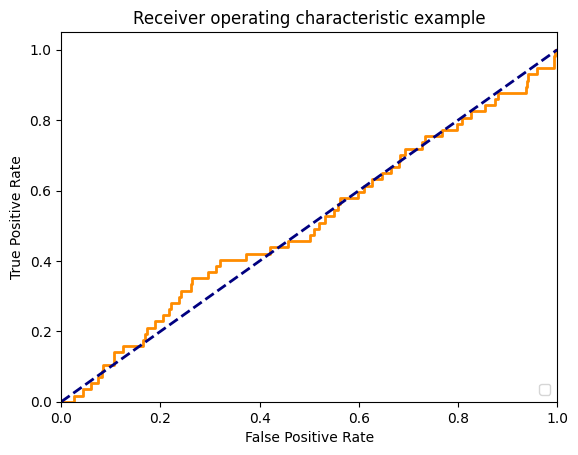

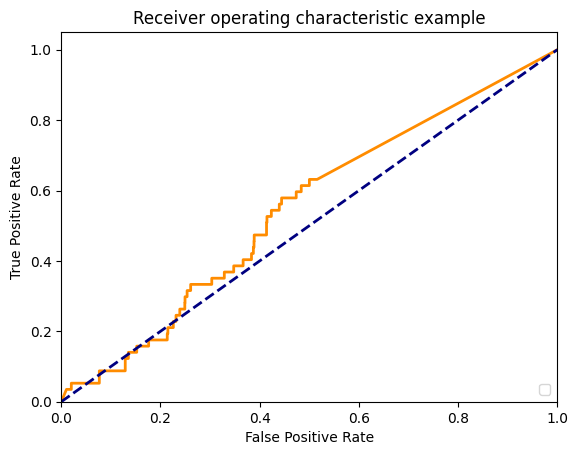

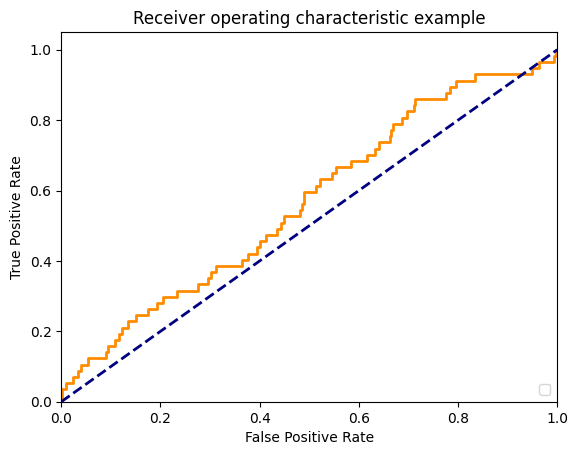

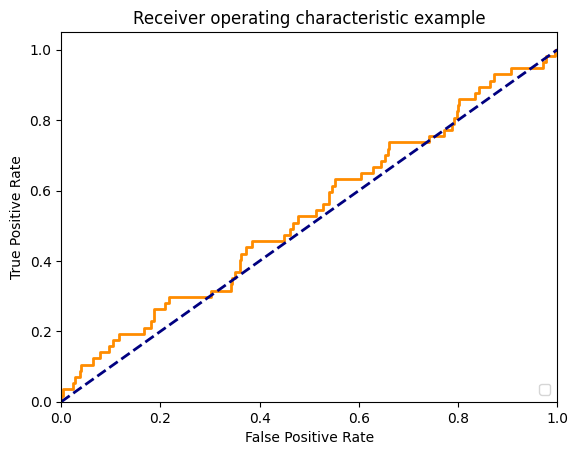

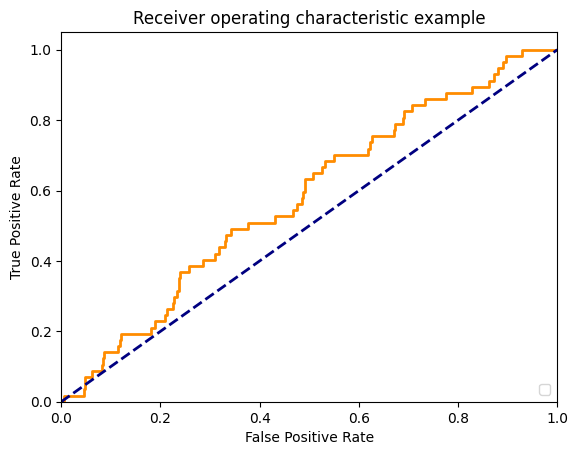

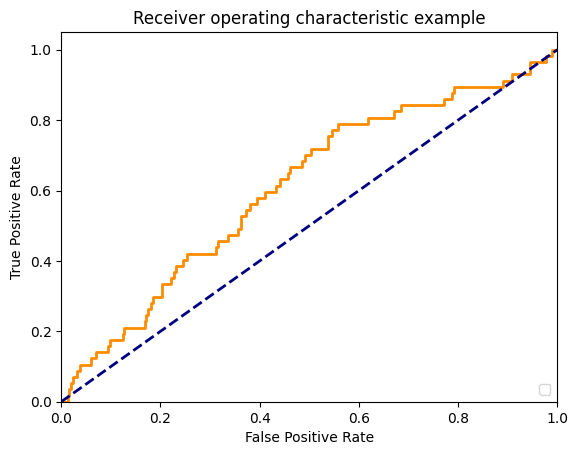

In [9]:
for iKey in model_dict:

    print(f'##### Now processing model {iKey} #####')
    LogMetrics(model_dict[iKey],X_test, y_test)

In [10]:
iKey = 'gb'
filename = 'data/best_model_'+iKey+'.sav'
joblib.dump(model_dict[iKey], filename)

['data/best_model_gb.sav']